In [1]:
import gzip, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from neurovlm.data import data_dir
from neurovlm.retrieval_resources import (
    _load_autoencoder,
    _load_specter,
    _load_dataframe,
    _load_latent_text, 
    _proj_head_text_mse,
    _load_masker
)
import torch.nn.functional as F
import nibabel as nib

masker = _load_masker()
df = _load_dataframe()
autoencoder = _load_autoencoder()
specter = _load_specter()
proj_head = _proj_head_text_mse()

There are adapters available but none are activated for the forward pass.


In [ ]:
# Load neurovault
neurovault_data = torch.load(
    data_dir / "neurovault.pt", weights_only=False
)
df_neuro, df_pubs, _, neuro_clust, _, _, text_emb = neurovault_data.values()

# Load networks
df = pd.read_excel(data_dir / "network_labelling.xlsx", sheet_name="generative_titles_neurovault")

# Sort
df_pubs = df_pubs.sort_values(by="doi").reset_index(drop=True)
df = df.sort_values(by="doi").reset_index(drop=True)
assert (df["doi"] == df_pubs["doi"]).all()

# Split by header
text = (df_pubs["title"] + "[SEP]" + df_pubs["abstract"]).tolist()
text_gen = []
text_gen_networks = []
text_gen_regions = []
text_gen_cognition = []
text_gen_clinical = []
for i in df["brain_to_text_summary"]:

    s = i.split("\n")
    title = s[0]

    abstract = " ".join([j for j in s[1:] if not j.startswith("###") and j != ""])
    abstract = abstract.replace("**", "")
    abstract = abstract.replace("__", "")
    title = title.replace("**", "")
    title = title.replace("__", "")
    text_gen.append(title + "[SEP]" + abstract)

    headers = ["### Networks", "### Key Regions", "### Cognitive Functions", "### Clinical Relevance"]
    idx = [idx for idx in range(len(s)) if s[idx] in headers]
    start = idx
    end = idx[1:]
    end.append(len(s))
    assert len(idx) == 4

    text_gen_networks.append("".join(s[start[0]:end[0]][1:]))
    text_gen_regions.append("".join(s[start[1]:end[1]][1:]))
    text_gen_cognition.append("".join(s[start[2]:end[2]][1:]))
    text_gen_clinical.append("".join(s[start[3]:end[3]][1:]))

In [7]:
df.sort_values(by="doi").reset_index(drop=True)

,pmid,pmcid,doi,name,description
0,21041607,NaN,10.1001/archgenpsychiatry.2010.154,Neural Correlates of Affect Processing and Agg...,CONTEXT: Methamphetamine abuse is associated w...
1,21199958,NaN,10.1001/archgenpsychiatry.2010.190,Effects of varenicline on smoking cue–triggere...,"CONTEXT\nVarenicline, an effective smoking ces..."
2,21555634,NaN,10.1001/archneurol.2011.94,Test-Retest Reliability of Memory Task fMRI in...,OBJECTIVE: To examine the feasibility and test...
3,17909128,NaN,10.1001/archpsyc.64.10.1163,Effect of Alzheimer Disease Risk on Brain Func...,CONTEXT: Asymptomatic middle-aged adult childr...
4,30646204,6420094.0,10.1001/jamanetworkopen.2018.6893,Neural Responsivity to Food Cues in Patients W...,\n## Importance \n \nSchizophrenia is associ...
...,...,...,...,...,...
30821,28877515,NaN,None,Neural congruence between intertemporal and in...,Behavioral studies using delay and social disc...
30822,28919871,NaN,None,Investigating the Neural Correlates of Emotion...,The human brain has the capacity to integrate ...
30823,32968547,7508465.0,None,Impact of Cannabis Use on Brain Structure and ...,\n## Background: \n \nBrain atrophy and cogn...
30824,22539870,3335782.0,None,Combination of blood oxygen level–dependent fu...,\n## Purpose \n \nTo elucidate the different...


In [ ]:
def embed(text, fname):
    with torch.no_grad():
        emb_gen = specter(text)
    torch.save(emb_gen, fname)

embed(text, "emb.pt")
embed(text_gen, "emb_gen.pt")
embed(text_gen_networks, "emb_gen_networks.pt")
embed(text_gen_regions, "emb_gen_regions.pt")
embed(text_gen_cognition, "emb_gen_cognition.pt")
embed(text_gen_clinical, "emb_gen_clinical.pt")

In [3]:
norm = lambda i : F.normalize(i, dim=1)
text_true = norm(torch.load("emb.pt"))
text_gen = norm(torch.load("emb_gen.pt"))
text_gen_networks = norm(torch.load("emb_gen_networks.pt"))
text_gen_regions = norm(torch.load("emb_gen_regions.pt"))
text_gen_cognition = norm(torch.load("emb_gen_cognition.pt"))
text_gen_clinical = norm(torch.load("emb_gen_clinical.pt"))

In [4]:
def compare(true, gen, ref=None, n_samples=100):

    # Normalize
    A = true
    B = gen

    if ref is not None:
        A = (A - ref) #/ ref.std()
        B = (B - ref) #/ ref.std()

    A = F.normalize(A, dim=1)
    B = F.normalize(B, dim=1)

    # True similarity distribution
    sim = (A * B).sum(dim=1)

    # Null distribution: randomly shuffle pairs
    sim_rand = torch.zeros((n_samples, len(sim)))
    for i in range(n_samples):
        inds = torch.randperm(len(A))
        sim_rand[i] = (A[inds] * B).sum(dim=1)

    return sim, sim_rand

In [5]:
train, test, val = torch.load(data_dir / "pmids_split.pt", weights_only=False).values()

latent_text, pmids_latent_text = _load_latent_text()
latent_neuro, pmids_latent_neuro = torch.load(data_dir / "latent_neuro.pt", weights_only=False).values()

latent_text_train = latent_text[pd.Series(pmids_latent_text).isin(train)]
latent_neuro_train = latent_neuro[pd.Series(pmids_latent_neuro).isin(train)]
latent_neuro_train = latent_neuro_train / latent_neuro_train.norm(dim=1)[:, None]

In [ ]:
def text_to_img(text_norm):
    with torch.no_grad():
        # imgs_gen = autoencoder.encoder(
        #     torch.sigmoid(autoencoder.decoder(proj_head(text_norm)))
        # )
        imgs_gen = proj_head(text_norm)
        imgs_gen = F.normalize(imgs_gen, dim=1)
    return imgs_gen

def neurovault_select(imgs_gen):
    imgs = torch.zeros_like(imgs_gen)
    for i, doi in enumerate(df_pubs["doi"]):
        with torch.no_grad():
            # Encoded image
            img = autoencoder.encoder(torch.from_numpy(
                neuro_clust[np.where(df_neuro["doi"] == doi)[0]] > 0
            ).to(torch.float32))
            img_norm = F.normalize(img, dim=1)
            imgs[i] = img_norm[(img_norm @ imgs_gen[i]).argmax()]
    return imgs

In [ ]:
imgs_gen_all = text_to_img(text_gen) # text_gen* is specter embeddings
imgs_all = neurovault_select(imgs_gen_all)

imgs_gen_networks = text_to_img(text_gen_networks)
imgs_networks = neurovault_select(imgs_gen_networks)

imgs_gen_regions = text_to_img(text_gen_regions)
imgs_regions = neurovault_select(imgs_gen_regions)

imgs_gen_cognition = text_to_img(text_gen_cognition)
imgs_cognition = neurovault_select(imgs_gen_cognition)

imgs_gen_clinical = text_to_img(text_gen_clinical)
imgs_clinical = neurovault_select(imgs_gen_clinical)

imgs_gen_clinical = text_to_img(text_gen_clinical)
imgs_clinical = neurovault_select(imgs_gen_clinical)

In [8]:
with torch.no_grad():
    ref_text = proj_head(latent_text_train).mean(axis=0)
ref_neuro = latent_neuro_train.mean(axis=0).to("cpu")

In [9]:
sim_all, sim_rand_all = compare(imgs_gen_all, imgs_all, ref=ref_neuro, n_samples=1_000)
sim_networks, sim_rand_networks = compare(imgs_gen_networks, imgs_networks, ref=ref_neuro, n_samples=1_000)
sim_regions, sim_rand_regions = compare(imgs_gen_regions, imgs_regions, ref=ref_neuro, n_samples=1_000)
sim_cognition, sim_rand_cognition = compare(imgs_gen_cognition, imgs_cognition, ref=ref_neuro, n_samples=1_000)
sim_clinical, sim_rand_clinical = compare(imgs_gen_clinical, imgs_clinical, ref=ref_neuro, n_samples=1_000)

In [10]:
imgs_gen = text_to_img(text_true) # true text -> predicted image
imgs = neurovault_select(imgs_gen)
with torch.no_grad():
    sim, sim_rand = compare(imgs, imgs_gen, ref=ref_neuro, n_samples=1_000)

Text(0, 0.5, 'Cosine Similarity')

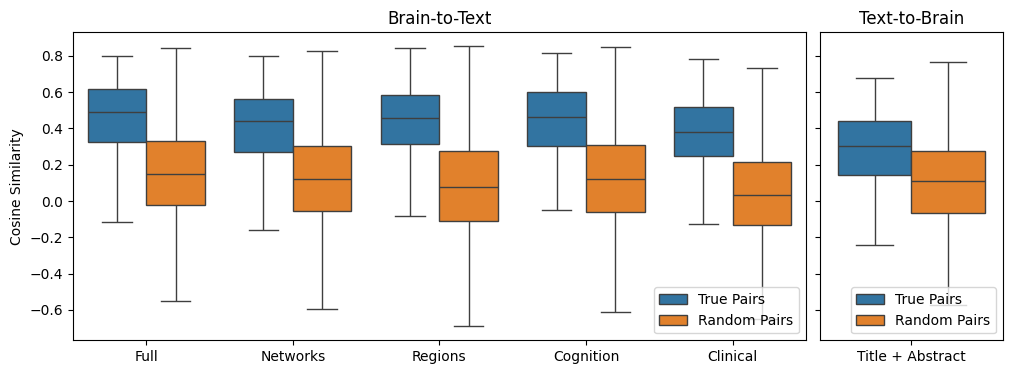

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

def paired_boxplot(
    true_vals_by_type: dict,
    gen_vals_by_type: dict,
    *,
    ax,
    order=("Full", "Networks", "Regions", "Cognition", "Clinical"),
    hue_order=("True Pairs", "Random Pairs"),
    showfliers=False,
    **kwargs,
):
    """
    Parameters
    ----------
    true_vals_by_type : dict[str, array-like]
        e.g. {"network": arr, "region": arr, ...}
    gen_vals_by_type : dict[str, array-like]
        same keys as true_vals_by_type
    ax : matplotlib.axes.Axes
    order : iterable[str]
        x-axis category order (Generation Type)
    hue_order : iterable[str]
        box order within each category
    showfliers : bool
    **kwargs : passed to seaborn.boxplot
    """
    rows = []
    for gtype in order:
        if gtype not in true_vals_by_type or gtype not in gen_vals_by_type:
            continue

        t = np.asarray(true_vals_by_type[gtype]).ravel()
        g = np.asarray(gen_vals_by_type[gtype]).ravel()

        rows.append(pd.DataFrame({"Generation Type": gtype, "Data": "True Pairs",   "Value": t}))
        rows.append(pd.DataFrame({"Generation Type": gtype, "Data": "Random Pairs", "Value": g}))

    df = pd.concat(rows, ignore_index=True)

    sns.boxplot(
        data=df,
        x="Generation Type",
        y="Value",
        hue="Data",
        order=[k for k in order if k in df["Generation Type"].unique()],
        hue_order=list(hue_order),
        ax=ax,
        showfliers=showfliers,
        **kwargs,
    )
    ax.set_xlabel("")
    ax.legend(loc="lower right")

    return df


fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 4),
    gridspec_kw={"width_ratios": [4, 1], "wspace": 0.03},
    sharey=True
)

_df = paired_boxplot(
    true_vals_by_type={
        "Full": sim_all,
        "Networks": sim_networks,
        "Regions": sim_regions,
        "Cognition": sim_cognition,
        "Clinical": sim_clinical,
    },
    gen_vals_by_type={
        "Full": sim_rand_all,
        "Networks": sim_rand_networks,
        "Regions": sim_rand_regions,
        "Cognition": sim_rand_cognition,
        "Clinical": sim_rand_clinical,
    },
    ax=axes[0],
    showfliers=False,
)

def _to_1d_numpy(x):
    try:
        import torch
        if isinstance(x, torch.Tensor):
            x = x.detach().cpu().numpy()
    except Exception:
        pass
    return np.asarray(x).ravel()

sim_np      = _to_1d_numpy(sim)
sim_rand_np = _to_1d_numpy(sim_rand)

df = pd.DataFrame({
    "Generation Type": np.repeat("Title + Abstract", sim_np.size + sim_rand_np.size),
    "group": np.repeat(["True Pairs", "Random Pairs"], [sim_np.size, sim_rand_np.size]),
    "value": np.concatenate([sim_np, sim_rand_np]),
})

ax = sns.boxplot(data=df, x="Generation Type", y="value", showfliers=False, ax=axes[-1], hue="group")
ax.set_xlabel("")
ax.legend(loc="lower right")
axes[0].set_title("Brain-to-Text")
axes[1].set_title("Text-to-Brain")
axes[0].set_ylabel("Cosine Similarity")

In [ ]:
_df = _df[_df["Generation Type"] == "Full"]
_df.rename(columns={"Data": "group", "Value": "value"}, inplace=True)
_df["Generation Type"] = "Brain-to-Text"
df["Generation Type"] = "Text-to-Brain"

Text(0.5, 1.0, 'Generative Latent Space Alignment')

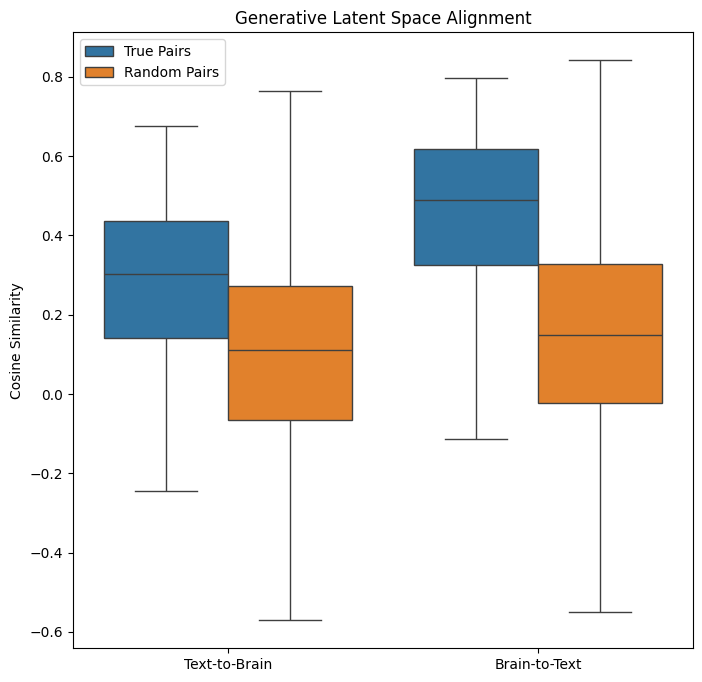

In [ ]:
df_stack = pd.concat((df, _df))
plt.figure(figsize=(8, 8))
sns.boxplot(data=df_stack, x="Generation Type", y="value", hue="group", showfliers=False)
plt.xlabel("")
plt.ylabel("")
plt.ylabel("Cosine Similarity")
plt.legend()
plt.title("Generative Latent Space Alignment")

## Text-to-Brain

In [32]:
import textwrap
from nilearn.plotting import plot_stat_map
from nilearn.image import threshold_img

In [33]:
labels, imgs = torch.load(data_dir / "network_examples.pt", weights_only=False).values()

In [34]:
text = {
    "Language": (
        "A left-dominant network supporting comprehension and production of language. "
        "Typically engaged by speech and text processing, semantic access, syntactic parsing, "
        "phonological processing, and verbal working memory during sentence-level integration."
    ),
    "Auditory": (
        "A network centered on primary and association auditory cortex that supports sound processing. "
        "Engaged by basic acoustic features (pitch, loudness, timbre), auditory scene analysis, "
        "speech perception at early stages, and detection of salient auditory events."
    ),
    "Default Mode": (
        "A network most active during internally focused cognition and relatively suppressed during demanding external tasks. "
        "Associated with episodic memory retrieval, self-referential thought, autobiographical reasoning, "
        "future simulation, theory of mind/social inference, and constructing coherent narratives/mental models."
    ),
    "Frontoparietal Control": (
        "A flexible 'executive control' network that coordinates goal-directed behavior across tasks. "
        "Supports adaptive cognitive control, task-set maintenance and switching, top-down attention, "
        "working memory manipulation, planning, and integrating information to guide decisions."
    ),
    "Attention": (
        "A set of networks (often including dorsal attention components) supporting externally directed attention. "
        "Engaged during visuospatial orienting, sustained attention, selection of task-relevant stimuli, "
        "top-down modulation of sensory areas, and attention-driven evidence accumulation."
    ),
    "Visual": (
        "A network spanning primary and higher-order visual cortex supporting perception and visual analysis. "
        "Engaged by visual feature processing (edges, motion, color), object/scene recognition, "
        "and visuospatial representations used for visually guided behavior and imagery."
    ),
    "Motor": (
        "A network spanning primary motor and somatosensory cortex supporting movement and bodily sensation. "
        "Engaged by motor planning and execution, proprioception, tactile processing, "
        "and sensorimotor integration for coordinated action."
    ),
    "Cingulo-Opercular": (
        "Cingulo-Opercular Network [SEP] "
        "The salience network (SN), also referred to as the midcingulo-insular network (M-CIN) or cingulo-opercular network,"
        "detects and filters behaviorally relevant internal and external events, integrates sensory, "
        "emotional, and interoceptive signals, and recruits other large-scale networks, often switching to guide attention."
    )
}
text = {k: k + " [SEP] " + v for k, v in text.items()}

In [35]:
# brain-to-text
# text-to-brain
with torch.no_grad():
    text_to_brain = torch.sigmoid(autoencoder.decoder(
        proj_head(F.normalize(specter([text[l] for l in labels]), dim=1))
    ))

text_to_brain = [masker.inverse_transform(i) for i in text_to_brain]

In [38]:
labels

[np.str_('Visual'),
 np.str_('Language'),
 np.str_('Auditory'),
 np.str_('Attention'),
 np.str_('Default Mode'),
 np.str_('Motor'),
 np.str_('Cingulo-Opercular'),
 np.str_('Frontoparietal Control')]

In [ ]:
from nilearn.datasets import load_mni152_template
from nilearn.image import resample_to_img
from nilearn.plotting import find_xyz_cut_coords
temp = load_mni152_template(resolution=1)

fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(2, 9))
wrap_width = 25

# manually choose slice planes for these
cut_coords = {str(k): None for k in labels}
cut_coords["Cingulo-Opercular"] = [-38, 18, 2]
cut_coords["Default Mode"] = [0, -56, 34]

for i in range(8):

    # Text
    s = text[labels[i]].replace(" [SEP] ", "\n\n")
    s = "\n".join(textwrap.fill(line, width=wrap_width) for line in s.splitlines())

    # Images
    thr_img = threshold_img(
        text_to_brain[i], "99%",
        cluster_threshold=25, two_sided=False, copy_header=True
    )
    thr_img = resample_to_img(thr_img, imgs[i])

    # Set slices with intersection
    coords = cut_coords[labels[i]]
    if coords is None:
        m = thr_img.get_fdata() == 0
        arr = imgs[i].get_fdata()
        arr[m] = 0
        coords = find_xyz_cut_coords(nib.Nifti1Image(arr, thr_img.affine))

    # Plot
    true = plot_stat_map(imgs[i], bg_img=temp, black_bg=False, colorbar=False, draw_cross=False, annotate=False, axes=axes[i, 1], threshold=0.01, cmap="Reds", cut_coords=coords)
    pred = plot_stat_map(thr_img, bg_img=temp, black_bg=False, colorbar=False, draw_cross=False, annotate=False, axes=axes[i, 0], vmin=0, vmax=1, threshold=0.01, cmap="hot", cut_coords=coords)

plt.savefig(data_dir / "qualatative_decoding.svg")

<positron-console-cell-39>:28: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
<positron-console-cell-39>:28: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.


KeyboardInterrupt: 

In [ ]:
temp = load_mni152_template(resolution=1)

# manually choose slice planes for these
cut_coords = {str(k): None for k in labels}
cut_coords["Cingulo-Opercular"] = [-38, 18, 2]
cut_coords["Default Mode"] = [0, -56, 34]

for i in range(8):

    if labels[i] != "Motor":
        continue
    

    # Text
    s = text[labels[i]].replace(" [SEP] ", "\n\n")
    s = "\n".join(textwrap.fill(line, width=wrap_width) for line in s.splitlines())

    # Images
    thr_img = threshold_img(
        text_to_brain[i], "99%",
        cluster_threshold=25, two_sided=False, copy_header=True
    )
    thr_img = resample_to_img(thr_img, imgs[i])

    # Set slices with intersection
    coords = cut_coords[labels[i]]
    if coords is None:
        m = thr_img.get_fdata() == 0
        arr = imgs[i].get_fdata()
        arr[m] = 0
        coords = find_xyz_cut_coords(nib.Nifti1Image(arr, thr_img.affine))

    # Plot
    true = plot_stat_map(imgs[i], bg_img=temp, black_bg=False, colorbar=False, draw_cross=False, annotate=False, threshold=0.01, cmap="Reds", cut_coords=coords)
    plt.savefig(data_dir / f"qualatative_decoding_{labels[i]}_true.png", dpi=300)
    plt.close()

    pred = plot_stat_map(thr_img, bg_img=temp, black_bg=False, colorbar=False, draw_cross=False, annotate=False, vmin=0, vmax=1, threshold=0.01, cmap="hot", cut_coords=coords)
    plt.savefig(data_dir / f"qualatative_decoding_{labels[i]}_pred.png", dpi=300)
    plt.close()

## Brain-to-Text

In [42]:
from tqdm.notebook import tqdm
from neurovlm.retrieval_resources import _load_masker
from nilearn.image import resample_to_img
from neurovlm.train import which_device

masker = _load_masker()

device = which_device()
proj_head_text = torch.load(data_dir / "proj_head_text_infonce.pt", weights_only=False).to("cpu")
proj_head_image = torch.load(data_dir / "proj_head_image_infonce.pt", weights_only=False).to("cpu")
ref = list(text.values())

# Encode networks
networks_emb = torch.zeros((len(imgs), 384))
for i, img in tqdm(enumerate(imgs), total=len(imgs)):
    with torch.no_grad():
        x = masker.transform(
            resample_to_img(img, masker.mask_img, interpolation="nearest", force_resample=True, copy_header=True)
        )
        x = autoencoder.encoder(torch.from_numpy(x))
        networks_emb[i] = x

  0%|          | 0/8 [00:00<?, ?it/s]

In [43]:
regions_map = {
    "Visual": [
        "Primary visual cortex",
        "Extrastriate visual cortex",
        "Lateral occipital cortex",
        "Fusiform gyrus",
        "Ventral occipitotemporal cortex",
        "Middle temporal visual area",
        "Lateral temporal-occipital",
        "Intraparietal visual",
        "Dorsal occipital-parietal"
    ],
    "Motor": [
        "Primary motor cortex",
        "Primary somatosensory cortex",
        "Premotor cortex",
        "Supplementary motor area",
        "Paracentral lobule",
        "Cerebellum",
        "Basal ganglia",
        "Thalamus"
    ],
    "Auditory": [
        "Primary auditory cortex",
        "Planum temporale",
        "Planum polare",
        "Superior temporal gyrus",
        "Superior temporal sulcus",
        "Insula",
    ],
    "Language": [
        "Inferior frontal gyrus",
        "Posterior superior temporal gyrus",
        "Middle temporal gyrus",
        "Anterior temporal lobe",
        "Angular gyrus",
        "Supramarginal gyrus",
    ],
    "Attention": [
        "Intraparietal sulcus",
        "Superior parietal lobule (dorsal)",
        "Frontal eye fields",
        "Superior frontal",
        "Temporoparietal junction",
        "Ventral frontal cortex",
        "Precuneus",
        "Parietal midline"
    ],
    "Frontoparietal Control": [
        "Dorsolateral prefrontal cortex",
        "Inferior frontal sulcus",
        "Lateral PFC",
        "Anterior prefrontal",
        "Inferior parietal lobule",
        "Intraparietal sulcus",
        "Lateral temporal cortex",
    ],
    "Cingulo-Opercular": [
        "Dorsal anterior cingulate cortex (dACC)",
        "Medial superior frontal cortex",
        "Anterior insula",
        "Frontal operculum",
        "Anterior prefrontal",
        "Anterior midline",
        "Thalamus",
    ],
    "Default Mode": [
        "Medial prefrontal cortex (mPFC)",
        "Posterior cingulate cortex",
        "Precuneus",
        "Angular gyrus",
        "Lateral inferior parietal cortex",
        "Lateral temporal cortex",
        "Retrosplenial",
        "Posterior midline regions",
        "Hippocampal formation",
    ],
    "Limbic Affective": [
        "Orbitofrontal cortex (medial & lateral OFC)",
        "Ventromedial prefrontal cortex (vmPFC)",
        "Temporal pole",
        "Anterior temporal cortex",
        "Amygdala",
        "Ventral striatum",
        "Nucleus accumbens",
        "Subgenual",
        "Ventral anterior cingulate"
    ],
    "Medial Temporal Lobe": [
        "Hippocampus",
        "Entorhinal cortex",
        "Parahippocampal cortex",
        "Perirhinal cortex",
        "Retrosplenial cortex",
        "Posterior cingulate cortex",
        "Posterior medial regions"
    ],
}

cognition_map = {
    "Visual": [
        "Visual perception",
        "Object recognition",
        "Face processing",
        "Scene processing",
        "Motion perception",
        "Visuospatial processing",
        "Visual attention",
    ],
    "Somatomotor": [
        "Voluntary movement execution",
        "Motor planning",
        "Somatosensory processing",
        "Touch",
        "Pain",
        "Temperature",
        "Proprioception",
        "Sensorimotor integration",
        "Motor learning",
        "Motor coordination"
    ],
    "Auditory": [
        "Auditory perception",
        "Pitch processing",
        "Sound localization",
        "Speech-sound processing",
        "Music perception",
    ],
    "Language": [
        "Speech comprehension",
        "Speech production",
        "Syntax processing",
        "Semantic processing",
        "Reading",
        "Lexical access",
        "Phonological processing",
    ],
    "Attention": [
        "Selective attention",
        "Spatial orienting",
        "Sustained attention",
        "Top-down attentional control",
        "Bottom-up reorienting"
    ],
    "Frontoparietal Control": [
        "Executive control",
        "Working memory",
        "Cognitive flexibility",
        "Task switching",
        "Rule/goal representation",
        "Decision making",
        "Planning",
        "Adaptive control",
    ],
    "Cingulo-Opercular": [
        "Salience detection ",
        "Performance monitoring",
        "Error detection",
        "Stable task-set maintenance",
        "Sustained control",
        "Autonomic coordination",
        "Interoception"
    ],
    "Default Mode": [
        "Self-referential thought",
        "Mind-wandering",
        "Spontaneous thought",
        "Autobiographical memory",
        "Future thinking",
        "Social cognition",
        "Theory of mind"
    ],
    "Limbic Affective": [
        "Emotion processing",
        "Affect regulation",
        "Reward valuation",
        "Motivation",
        "Approach-avoidance",
        "Social-emotional appraisal",
    ],
    "Medial Temporal Lobe": [
        "Episodic memory",
        "Encoding",
        "Retrieval",
        "Relational memory",
        "Associative memory",
        "Context binding",
        "Spatial navigation",
        "Memory consolidation",
    ],
}

network_labels = list(regions_map.keys())
network_labels = [i for i in network_labels if i != "Limbic Affective"]
region_labels = np.unique(sum(list(regions_map.values()), [])).tolist()
cognition_labels =  np.unique(sum(list(cognition_map.values()), [])).tolist()

In [44]:
with torch.no_grad():
    text_networks_emb = F.normalize(specter(network_labels), dim=1)
    text_networks_emb = F.normalize(proj_head_text(text_networks_emb), dim=1)

    text_regions_emb = F.normalize(specter(region_labels), dim=1)
    text_regions_emb = F.normalize(proj_head_text(text_regions_emb), dim=1)

    text_cognition_emb = F.normalize(specter(cognition_labels), dim=1)
    text_cognition_emb = F.normalize(proj_head_text(text_cognition_emb), dim=1)

In [45]:
x = F.normalize(proj_head_image(networks_emb), dim=1)

pred_networks = [network_labels[i] for i in (x @ text_networks_emb.T).argmax(dim=1)]
pred_regions = [[region_labels[j] for j in i] for i in (x @ text_regions_emb.T).argsort(dim=1, descending=True)[:, :5]]
pred_cognition = [[cognition_labels[j] for j in i] for i in (x @ text_cognition_emb.T).argsort(dim=1, descending=True)[:, :5]]
terms = [[a + " Network"] + b + c for a, b, c in zip(pred_networks, pred_regions, pred_cognition)]

In [46]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Load LLM
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side="left")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

model.config.pad_token_id = tokenizer.pad_token_id

# Eval mode and disable gradients
model.eval()
for p in model.parameters():
    p.requires_grad_(False)
torch.set_grad_enabled(False)

Some parameters are on the meta device because they were offloaded to the cpu.


torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [47]:
system_prompt = """
You are a neuroscience editor writing a short summary from a list of terms.

INPUT: a list of neuroscience terms.
OUTPUT: a short summary of the implicated network

Rules:
A single summary paragraph (3 sentences). Be specific. NO vague statements. No adjectives. Explain the terms given to you:
   - Sentence 1: Key regions
   - Sentence 2: Related cognition
   - Sentence 3: Clinical relevance

No references. Do not mention this prompt. Only include a single summary paragraph.
""".strip()

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

Device set to use cuda:0


In [48]:
messages = []
for t in terms:
    with torch.no_grad():
        messages.append([
            {"role": "system", "content": system_prompt.strip("\n")},
            {"role": "user", "content": "\n".join(t)}
        ])

with torch.inference_mode():
    outputs = pipe(
        messages,
        max_new_tokens=200,
        do_sample=True,
        temperature=0.2,
        top_p=0.95,
        top_k=50,
        repetition_penalty=1.1,
        return_full_text=True,
        padding=True,
        truncation=True
    )

In [49]:
generated_summaries = [out[0]["generated_text"][-1]["content"].strip() for out in outputs]

df_gen = pd.DataFrame(dict(
    true_labels=labels,
    predicted_terms=["\n".join(i) for i in terms],
    summary=generated_summaries
))

df_gen

,true_labels,predicted_terms,summary
0,Visual,Visual Network\nIntraparietal visual\nExtrastr...,The key regions involved in the visual network...
1,Language,Language Network\nLateral temporal cortex\nAnt...,The language network primarily involves key re...
2,Auditory,Auditory Network\nPrimary auditory cortex\nSup...,The auditory network is primarily composed of ...
3,Attention,Attention Network\nDorsal occipital-parietal\n...,The Attention Network involves key regions inc...
4,Default Mode,Default Mode Network\nMedial prefrontal cortex...,The Default Mode Network is primarily composed...
5,Motor,Motor Network\nPrimary motor cortex\nSupplemen...,The motor network primarily involves the prima...
6,Cingulo-Opercular,Cingulo-Opercular Network\nAnterior prefrontal...,The Cingulo-Opercular Network is primarily com...
7,Frontoparietal Control,Frontoparietal Control Network\nMedial prefron...,The Frontoparietal Control Network is primaril...


In [50]:
df_gen.to_csv(data_dir / "networks_text_gen.csv")